# Laboratorio: Trattamento Variabili Categoriche e Alberi di Regressione

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Proff. Gianluca Moro, Roberto Pasolini  
`nome.cognome@unibo.it`

## Setup

- Importiamo le librerie di uso comune

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import warnings
warnings.filterwarnings('once')

- Definiamo la seguente funzione di supporto per scaricare i file di dati necessari

In [2]:
import os
from urllib.request import urlretrieve
def download(file, url):
    if not os.path.isfile(file):
        urlretrieve(url, file)

- Installeremo e testeremo altre librerie nella parte finale dell'esercitazione

## Caso di studio: Predizione vendite

- I negozi sono interessati a prevedere quanto più accuratamente possibile le vendite giornaliere
  - per ottimizzare le scorte di magazzino, il personale da impiegare, ecc.
- Le vendite sono influenzate da diversi fattori
  - giorno della settimana, festività, promozioni, ...
- In questo caso di studio analizziamo dati relativi a più di 1.000 negozi della catena europea Rossmann
- La predizione su questi dati è stata oggetto di una competizione su Kaggle: https://www.kaggle.com/c/rossmann-store-sales
  - i dati che forniamo sono versioni già parzialmente preprocessate di quelli originali su Kaggle

### Dataset

- I dati sono forniti divisi in due file, per addestramento e validazione

In [3]:
download("rossmann_train.csv.gz", "https://github.com/datascienceunibo/dialab2019/raw/master/Deep_Learning/rossmann_train.csv.gz")
download("rossmann_valid.csv.gz", "https://github.com/datascienceunibo/dialab2019/raw/master/Deep_Learning/rossmann_valid.csv.gz")

- Carichiamo i due file e vediamone la quantità di osservazioni
  - con `parse_dates=["Date"]` ci accertiamo che la colonna della data sia trattata come tale
  - i file CSV sono compressi col formato GZIP, lo esplicitiam con `compression="gzip"`

In [4]:
data_train = pd.read_csv(
    "rossmann_train.csv.gz",
    parse_dates=["Date"],
    compression="gzip",
)

In [5]:
data_val = pd.read_csv(
    "rossmann_valid.csv.gz",
    parse_dates=["Date"],
    compression="gzip",
)

In [6]:
len(data_train), len(data_val)

(804056, 40282)

- Vediamo un estratto dei due frame

In [7]:
data_train.head(4)

,Store,Date,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,CompetitionOpen,PromoOpen,IsPromoMonth,Customers,Sales
0,314,2015-06-19,1,0,0,1,1,3560.0,10.0,2001.0,1,31.0,2013.0,164.0,22.50,0,562,5032
1,458,2015-06-19,1,0,0,3,1,3390.0,0.0,0.0,0,0.0,0.0,24186.0,24186.25,0,688,7362
2,961,2015-06-19,1,0,0,4,3,9430.0,0.0,0.0,0,0.0,0.0,24186.0,24186.25,0,768,7764
3,132,2015-06-19,1,0,0,4,3,1040.0,0.0,0.0,1,27.0,2012.0,24186.0,35.50,0,692,7964


In [8]:
data_val.head(4)

,Store,Date,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,CompetitionOpen,PromoOpen,IsPromoMonth,Customers,Sales
0,1,2015-07-31,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,82.0,24187.75,0,555,5263
1,747,2015-07-31,1,0,1,3,3,45740.0,8.0,2008.0,0,0.0,0.0,83.0,24187.75,0,826,10708
2,772,2015-07-31,1,0,1,4,3,1850.0,0.0,0.0,0,0.0,0.0,24187.0,24187.75,0,635,5224
3,752,2015-07-31,1,0,1,1,1,970.0,3.0,2013.0,1,31.0,2013.0,28.0,24.00,0,565,7763


### Descrizione variabili

- Ogni riga è un'osservazione relativa ad un singolo negozio in una certa data, indicati dalle colonne `Store` e `Date`
- Le ultime due colonne `Customers` and `Sales` indicano rispettivamente il numero di clienti e il ricavo totale delle vendite per quel giorno in quel negozio
- Le altre colonne riportano informazioni note a priori relative a negozio e giorno
  - applicazione di promozioni (`Promo*`, `IsPromoMonth`)
  - festività (`StateHoliday`, `SchoolHoliday`)
  - tipologia di negozio (`StoreType`, `Assortment`)
  - distanza da negozi concorrenti e loro data di apertura (`Competition*`)
- L'obiettivo è prevedere da queste informazioni il ricavo totale (`Sales`)
- Definiamo le serie `y_*` con i valori di `Sales` per training e validation set

In [9]:
y_train = data_train["Sales"]
y_val = data_val["Sales"]

- Il ricavo totale `Sales` è ovviamente strettamente proporzionale al numero di clienti `Customers`
  - usiamo il metodo `sample` per selezionare un numero dato di campioni casuali per creare il grafico con più efficienza

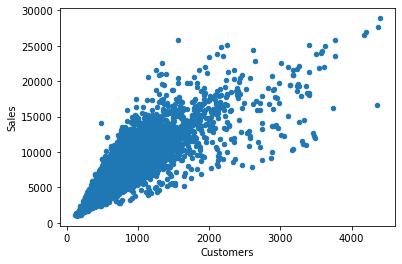

In [10]:
data_train.sample(10000, random_state=42).plot.scatter("Customers", "Sales");

- Non possiamo però usare la variabile `Customers` nella predizione, in quanto proprio come `Sales` non è un'informazione nota a priori
  - _Quando si utilizza un dataset per addestrare un modello di predizione, verificare sempre attentamente quali informazioni è lecito utilizzare!_

## Tipi di variabili

- Le altre colonne contengono variabili utilizzabili per la predizione, tra le quali possiamo distinguere
  - variabili _numeriche_ (es. `CompetitionDistance`) simili a quelle viste nelle esercitazioni precedenti
  - variabili _categoriche_ (es. `StoreType`), ciascuna delle quali può assumere un insieme finito di valori
- Definiamo una lista di variabili numeriche e una di variabili categoriche, che utilizzeremo in seguito

- Le altre colonne contengono variabili utilizzabili per la predizione
- Tutte le variabili hanno valori numerici, ma di diversa natura:
  1. alcune variabili (es. `CompetitionDistance`) esprimono effettivamente una quantità o una grandezza (sono di tipo "intervallo" o "ratio")
  2. altre variabili (es. `SchoolHoliday`) sono binarie, valgono 1 dove una condizione è verificata e 0 dove non si verifica
  3. altre variabili (es. `StoreType`) esprimono dei "codici", i numeri servono solamente da identificatori univoci (sono di tipo "nominale")
- Creiamo tre liste con i nomi delle variabili presenti nei rispettivi gruppi

In [11]:
numeric_vars = [
    "CompetitionOpen", "CompetitionDistance",
    "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear",
    "Promo2SinceWeek", "Promo2SinceYear", "PromoOpen"
]
binary_vars = ["Promo", "SchoolHoliday", "Promo2", "IsPromoMonth"]
categorical_vars = ["StateHoliday", "StoreType", "Assortment"]

- I metodi di regressione e classificazione visti finora funzionano con variabili predittive numeriche
  - di queste viene ad es. calcolata una combinazione lineare secondo i coefficienti appresi dal modello
- Questi modelli **non funzionano** in presenza di variabili categoriche
  - le variabili categoriche sono spesso codificate in modo non numerico (es. strighe): se si provasse ad addestrare un modello di regressione su di esse avremmo un errore
  - anche se codificate numericamente, gli algoritmi dedurrebbero erroneamente ad es. che lo `StoreType` 1 è più simile al 2 che al 4, in realtà ognuno può avere un peso diverso e indipendente dagli altri nella predizione

## Esercizio 1: Classificazione sulle sole variabili numeriche

- **(1a)** Definire `X_train_num` e `X_val_num` come proiezioni dei frame `X_train` e `X_val` contenenti le soli variabili numeriche e binarie del dataset
  - usare `+` per concatenare le due relative liste di variabili
- **(1b)** Addestrare un modello di regressione Ridge con $\alpha=1$ (default) su `X_train_num` e verificarne l'accuratezza su `X_val_num`
- **(1c)** Addestrare e verificare lo stesso modello sugli stessi dati, ma utilizzando una pipeline per standardizzare i dati

In [12]:
# import necessari
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [13]:
X_train_num, X_val_num = data_train[numeric_vars + binary_vars], data_val[numeric_vars + binary_vars]

In [14]:
r_model = Ridge(alpha=1) # alpha=1 è di default
r_model.fit(X_train_num, y_train)
print("R^2 : ", r_model.score(X_val_num, y_val))

R^2 :  0.18368590092846326


In [15]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=1))
])
model.fit(X_train_num, y_train)
print("R^2 : ", model.score(X_val_num,y_val))

R^2 :  0.1917773276900372


## Trattamento delle variabili categoriche: one-hot encoding

- Come si possono utilizzare le variabili categoriche in modelli di regressione?
- La soluzione tipica consiste nel convertire le variabili categoriche in numeriche
- Data una variabile categorica X con N valori possibili $a, b, c, \ldots$, il _one-hot encoding_ consiste nel convertirla in N variabili numeriche binarie $X_a, X_b, X_c, \ldots$
- Ciascuna variabile $X_v$
  - vale 1 nei casi in cui $X = v$
  - vale 0 negli altri casi
- Ogni valore di X è in pratica convertito ad un vettore in $\mathbf{R}^N$ con un elemento a 1 e gli altri a 0
  - $a \rightarrow [1,0,0,\ldots]$
  - $b \rightarrow [0,1,0,\ldots]$
  - $c \rightarrow [0,0,1,\ldots]$
  - ...

- scikit-learn fornisce un filtro `OneHotEncoder` per effettuare questa operazione su tutte le variabili di un dataset
- Analizziamone il funzionamento su una variabile binaria e una categorica del dataset

In [16]:
X_sample = data_train[["SchoolHoliday", "StateHoliday"]]
X_sample.head(5)

,SchoolHoliday,StateHoliday
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


- I valori possibili di queste variabili sono:
- unique() restituisce i valori diversi per la colonna (serie) selezionata

In [17]:
X_sample["SchoolHoliday"].unique()

array([0, 1], dtype=int64)

In [18]:
X_sample["StateHoliday"].unique()

array([0, 1, 2, 3], dtype=int64)

- Creiamo un'istanza del filtro specificandone i parametri
  - normalmente il filtro fornisce in uscita matrici sparse, come `CountVectorizer` e `TfidfVectorizer`
  - `sparse=False` indica di generare dei normali array NumPy, lo usiamo per fini dimostrativi

In [19]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)

- Come per gli altri filtri, passiamo il primo set di dati a `fit_transform` in modo che il formato dei dati venga appreso

In [20]:
encoder.fit_transform(X_sample)

array([[1., 0., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0., 0.]])

- Il filtro ha generato 6 variabili: una per ogni valore possibile per ogni variabile
- In ogni riga è presente un 1 nelle prime 2 colonne (`SchoolHoliday`) e un altro 1 nelle ultime 4 (`StateHoliday`)
- Col metodo `get_feature_names` (`get_feature_names_out` in versioni recenti di scikit-learn) è possibile vedere a quale valore corrisponde ciascuna colonna

In [21]:
encoder.get_feature_names()

array(['x0_0', 'x0_1', 'x1_0', 'x1_1', 'x1_2', 'x1_3'], dtype=object)

In [22]:
encoder.get_feature_names(["SH","SH"])

array(['SH_0', 'SH_1', 'SH_0', 'SH_1', 'SH_2', 'SH_3'], dtype=object)

- Passiamo i nomi delle colonne al metodo per utilizzarli al posto di `x0` e `x1`

In [23]:
encoder.get_feature_names(X_sample.columns)

array(['SchoolHoliday_0', 'SchoolHoliday_1', 'StateHoliday_0',
       'StateHoliday_1', 'StateHoliday_2', 'StateHoliday_3'], dtype=object)

- Usiamo i nomi per visualizzare la matrice ottenuta sopra in un frame

In [24]:
pd.DataFrame(
    encoder.transform(X_sample),
    columns=encoder.get_feature_names(X_sample.columns)
).head(5)

,SchoolHoliday_0,SchoolHoliday_1,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3
0,1.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0


- Specificando `drop="first"` nei parametri, `OneHotEncoder` genera una variabile binaria in meno per ogni variabile categorica, rappresentando uno dei valori possibili come un vettore di soli zero
- Il vantaggio è che per i modelli dove non c'è regolarizzazione dei dati una colonna che deriva da altre possono dare problemi

In [25]:
encoder = OneHotEncoder(drop="first", sparse=False)
pd.DataFrame(
    encoder.fit_transform(X_sample),
    columns=encoder.get_feature_names(X_sample.columns)
).head(5)

,SchoolHoliday_1,StateHoliday_1,StateHoliday_2,StateHoliday_3
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0


- In questo esempio sono state scartate le variabili `SchoolHoliday_0` e `StateHoliday_0`
  - i casi `SchoolHoliday_0` si riconoscono implicitamente da `SchoolHoliday_1 = 0`
  - i casi `StateHoliday_0` si riconoscono da tutte le colonne `StateHoliday` a 0
- Il vantaggio di questo accorgimento è che si evita di introdurre variabili collineari che possono causare problemi in alcuni modelli (es. modelli lineari senza regolarizzazione)
- Lo svantaggio è che si introduce un'asimmetria nella rappresentazione dei dati che può causare bias in altri modelli (es. modelli lineari con regolarizzazione)

- Usiamo ora il filtro `OneHotEncoder` per addestrare e validare un classificatore basato su tutte le variabili categoriche non binarie
- Creiamo delle proiezioni delle matrici `data_train` e `data_val` contenenti le sole variabili categoriche

In [26]:
X_train_cat = data_train[categorical_vars]
X_val_cat = data_val[categorical_vars]

- Creiamo un nuovo encoder
  - questa volta lasciamo le impostazioni di default, per cui vengono restituite matrici sparse (convertibili a normali array col metodo `toarray()`)

In [27]:
encoder = OneHotEncoder()

- Addestriamo un semplice modello di regressione ridge sul training set, addestrando ed applicando (`fit_transform`) l'encoder su di esso

In [28]:
model = Ridge()
model.fit(encoder.fit_transform(X_train_cat), y_train);

- Calcoliamo quindi l'accuratezza del modello sul validation set, che viene preprocessato usando lo stesso encoder

In [29]:
model.score(encoder.transform(X_val_cat), y_val)

0.05517909425317136

## Esercizio 2: One-hot encoding in una pipeline

- Utilizzando l'interfaccia standard dei filtri di scikit-learn, il one-hot encoder può essere utilizzato in una pipeline
- Definire un modello di regressione ridge come quello addestrato sopra in una pipeline che applichi l'encoding delle variabili categoriche, addestrarlo su `X_train_cat` e validarlo su `X_val_cat`

In [30]:
model = Pipeline([
    ("encoder", OneHotEncoder()),
    ("ridge", Ridge())
])
model.fit(X_train_cat, y_train)
model.score(X_val_cat, y_val)

0.05517909425317136

## Preprocessing differenziato delle colonne

- Abbiamo visto come addestrare modelli basati su variabili numeriche oppure su variabili categoriche
- È possibile utilizzare tutte le variabili (numeriche e categoriche) in un unico modello?
- Il one-hot encoder converte le variabili categoriche in numeriche, queste possono essere combinate a quelle che sono già numeriche
- Vediamo come eseguire questa procedura manualmente, applicando anche la standardizzazione alle variabili numeriche
- Per prima cosa, creiamo uno `StandardScaler` per le variabili già numeriche e un `OneHotEncoder` per quelle categoriche

In [31]:
scaler = StandardScaler()
encoder = OneHotEncoder(sparse=False)

- Quindi applichiamo i filtri alle rispettive colonne del training set e concateno per colonne le matrici ottenute
  - `np.c_[A, B, C, ...]` costruisce un array concatenendo per colonne (orizzontalmente) gli array A, B, C, ...
  - si può eseguire la stessa operazione per righe (verticalmente) con `np.r_`

In [32]:
X_train_combo = np.c_[
    scaler.fit_transform(X_train_num),
    encoder.fit_transform(X_train_cat)
]

- Eseguiamo la stessa operazione sul validation set usando i filtri già addestrati

In [33]:
X_val_combo = np.c_[
    scaler.transform(X_val_num),
    encoder.transform(X_val_cat)
]

- Infine addestriamo e validiamo un modello utilizzando le matrici combinate

In [34]:
model = Ridge()
model.fit(X_train_combo, y_train)
model.score(X_val_combo, y_val)

0.24806857504695334

- In questo modo abbiamo costruito un modello combinando insieme matrici numeriche e categoriche
- Abbiamo però svolto operazioni diverse dalle solite che definiamo in una pipeline
  - suddivisione del dataset in gruppi di colonne
  - applicazione di filtri diversi a ciascun gruppo
  - concatenazione delle colonne risultanti da ciascun gruppo

- Per questi casi, scikit-learn fornisce un filtro composito `ColumnTransformer`
- Un oggetto `ColumnTransformer` è definito da una lista di gruppi, ciascuno dei quali è definito da una tupla contenente:
  - un nome da dare al gruppo, usato per riferirsi ad esso, simile ai nomi in una `Pipeline`
  - un filtro da applicare al gruppo
    - può essere una `Pipeline` con una sequenza di filtri
  - una lista di nomi di colonne che fanno parte del gruppo
    - se le colonne non hanno nome (es. array NumPy), usare gli indici
- Definiamo ad esempio un `ColumnTransformer` che applichi `StandardScaler` e `OneHotEncoder` sui due gruppi di colonne come sopra

In [35]:
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer([
    # nome           filtro              colonne
    # stringa        classe di sklearn   lista
    #                per fare filtri
    ( "numeric"    , StandardScaler(), numeric_vars + binary_vars ),
    ( "categorical", OneHotEncoder() , categorical_vars           )
])

- Il trasformatore ha la stessa interfaccia di un filtro, possiamo quindi usarlo come sempre per trasformare il training set e il validation set
  - passiamo i due set per intero: il trasformatore li suddividerà in gruppi da trattare separatamente secondo la definizione sopra

In [36]:
X_train_proc = preprocessor.fit_transform(data_train)
X_val_proc = preprocessor.transform(data_val)

- Il risultato è esattamente uguale a quello ottenuto sopra concatenando gli array risultanti dalle applicazioni dei filtri sui dati separati manualmente

In [37]:
np.array_equal(X_train_combo, X_train_proc)

True

In [38]:
np.array_equal(X_val_combo, X_val_proc)

True

In [39]:
model = Ridge()
model.fit(X_train_proc, y_train)
model.score(X_val_proc, y_val)

0.24806857504695334

- Anche il `ColumnTransformer`, essendo un filtro, può essere usato all'interno di una pipeline
- Otteniamo così anche in questo caso un unico oggetto composito che contiene il modello di classificazione insieme a tutti i filtri da applicare ai dati

In [40]:
# definizione con transformer definito a parte
transformer = ColumnTransformer([
    ("numeric"    , StandardScaler(), numeric_vars + binary_vars),
    ("categorical", OneHotEncoder() , categorical_vars)
])
model = Pipeline([
    ("preproc", transformer),
    ("regr"   , Ridge())
])

# definizione equivalente con transformer innestato
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", StandardScaler(), numeric_vars + binary_vars),
        ("categorical", OneHotEncoder(), categorical_vars)
    ])),
    ("regr", Ridge())
])
model.fit(data_train, y_train)
model.score(data_val, y_val)

0.24806857504695334

- Analogamente a `Pipeline.named_steps`, `ColumnTranformers` permette di accedere ai singoli filtri tramite il dizionario `named_transformers_`
- Ad esempio, per ispezionare le medie rilevate sul training set dallo `StandardScaler` sulle variabili numeriche:

In [41]:
pd.Series(
    model.named_steps["preproc"].named_transformers_["numeric"].mean_,
    index=numeric_vars + binary_vars
)

CompetitionOpen               7731.256875
CompetitionDistance           5445.036515
CompetitionOpenSinceMonth        4.926207
CompetitionOpenSinceYear      1369.652314
Promo2SinceWeek                 11.573756
Promo2SinceYear               1001.963511
PromoOpen                    12145.351147
Promo                            0.447946
SchoolHoliday                    0.186730
Promo2                           0.498055
IsPromoMonth                     0.168130
dtype: float64

- Nella definizione del `ColumnTransformer` si può usare la stringa `"passthrough"` al posto di un filtro per utilizzare i dati senza applicare filtri
- Come ulteriore opzione, si può utilizzare la stringa `"drop"` per scartare completamente i dati
- Ad esempio, modifichiamo la pipeline sopra per suddividere le variabili numeriche da quelle binarie e non applicare la standardizzazione (non necessaria) a queste ultime

In [42]:
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric",     StandardScaler(), numeric_vars),
        ("binary",      "passthrough",    binary_vars),       # <---
        ("categorical", OneHotEncoder(),  categorical_vars)
    ])),
    ("regr", Ridge())
])
model.fit(data_train, y_train)
model.score(data_val, y_val)

0.2483045167103518

- Si può anche usare l'opzione `remainder` per indicare un filtro o un comportamento di default da applicare alle colonne che non fanno parte di alcun gruppo
- Riscriviamo l'esempio sopra definendo esplicitamente il gruppo di variabili categoriche e quello di variabili del dataset da NON usare come X e definendo il comportamento per tutte le altre
  - di default `remainder="drop"`, ovvero tutte le variabili non processate sono scartate

In [43]:
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("categorical", OneHotEncoder(), categorical_vars),
        ("unused",      "drop",          ["Store", "Date", "Customers", "Sales"])
    ], remainder="passthrough")),                          # <---
    ("regr", Ridge())
])
model.fit(data_train, y_train)
model.score(data_val, y_val)

0.23989956065358742

- In una grid search, possiamo riferirci ai singoli filtri del transformer e ai loro parametri con modalità analoghe a quelle viste nelle pipeline più semplici
  - si ipotizzi di avere un transformer come componente di una pipeline con nome `preproc`, come negli esempi sopra
  - per riferirsi al filtro di un gruppo `group`, si indica `preproc__group`
  - per riferirsi al parametro `par` di tale filtro, si indica `preproc__group__par`
- Definiamo ad esempio una grid search con modello simile a quello sopra in cui
  - alle variabili numeriche può essere applicato o meno `StandardScaler`
  - il one-hot encoding delle variabili categoriche può essere applicato con `drop="first"` o `drop=None` (default)

In [44]:
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", ..., numeric_vars),  # possiamo usare un valore arbitrario al posto di "..."
        ("binary", "passthrough", binary_vars),
        ("categorical", OneHotEncoder(), categorical_vars)
    ])),
    ("regr", Ridge())
])
grid = {
    # variazione dell'intero filtro da usare
    "preproc__numeric": ["passthrough", StandardScaler()],
    # variazione di un singolo parametro di un filtro
    "preproc__categorical__drop": [None, "first"]
}

- Eseguiamo la grid search, usando ad esempio la cross validation a 3 fold

In [45]:
from sklearn.model_selection import GridSearchCV, KFold
kf = KFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, grid, cv=kf)
gs.fit(data_train, y_train);

- Vediamo la configurazione migliore individuata e il confronto tra tutte quelle testate

In [46]:
gs.best_params_

{'preproc__categorical__drop': None, 'preproc__numeric': 'passthrough'}

In [47]:
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preproc__categorical__drop,param_preproc__numeric,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.519951,0.012433,0.149249,0.009292,None,passthrough,"{'preproc__categorical__drop': None, 'preproc_...",0.203672,0.205190,0.204515,0.204459,0.000621,1
2,0.552557,0.012640,0.178642,0.004261,first,passthrough,"{'preproc__categorical__drop': 'first', 'prepr...",0.203672,0.205190,0.204515,0.204459,0.000621,2
1,0.644412,0.007778,0.169534,0.002951,None,StandardScaler(),"{'preproc__categorical__drop': None, 'preproc_...",0.200944,0.202868,0.202179,0.201997,0.000796,3
3,0.675843,0.014720,0.199612,0.006602,first,StandardScaler(),"{'preproc__categorical__drop': 'first', 'prepr...",0.200944,0.202868,0.202179,0.201997,0.000796,4


## Esercizio 3: Grid search su pipeline complessa

- Effettuare la grid search con cross validation come sopra (`kf`) ed estrarre la configurazione migliore e l'accuratezza sul validation set su
  - **(3a)** un modello di regressione ridge su tutte le variabili con
    - one-hot encoding delle variabili categoriche con tutte le impostazioni di default
    - generazione di feature polinomiali dalle variabili numeriche e binarie con grado da 1 a 3
    - parametro `alpha` della regressione ridge pari a 0.01 o 1
  - **(3b)** un modello simile, ma con standardizzazione delle variabili numeriche e binarie prima di generare le feature polinomiali
    - utilizzare una pipeline per concatenare i due filtri
- Per ridurre i tempi di calcolo, utilizzare il dataset `data_train_sample` + `y_train_sample` creato sotto, composto da 60000 istanze prese casualmente del training set

In [48]:
# il metodo sample seleziona casualmente un sottoinsieme di righe del DataFrame
data_train_sample = data_train.sample(60000, random_state=42)
# il metodo reindex_like seleziona dalla serie le istanze corrispondenti
y_train_sample = y_train.reindex_like(data_train_sample)

In [49]:
from sklearn.preprocessing import PolynomialFeatures

In [50]:
r_model = Pipeline([
    ("preproc", ColumnTransformer([
        ("num", PolynomialFeatures(include_bias=False), numeric_vars + binary_vars),
        ("cat", OneHotEncoder(), categorical_vars)
    ])),
    ("ridgle", Ridge())
])
grid = {
    "preproc__num__degree" : [1,2,3],
    "ridgle__alpha" : [0.01, 1]
}
gs = GridSearchCV(r_model, grid, cv=kf)
gs.fit(data_train_sample, y_train_sample)
print(gs.best_params_)
print(gs.score(data_val, y_val))

C:\Users\Federico\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.00675e-24): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Federico\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.10634e-24): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Federico\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.05383e-24): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Federico\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.09632e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Federico\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.20538e-22): result may 

{'preproc__num__degree': 3, 'ridgle__alpha': 1}
0.27430283128068667


In [51]:
r_model = Pipeline([
    ("preproc", ColumnTransformer([
        ("num", Pipeline([
            ("scaler", StandardScaler()),
            ("poly", PolynomialFeatures(include_bias=False))
        ]), numeric_vars + binary_vars),
        ("cat", OneHotEncoder(), categorical_vars),
    ])),
    ("ridgle", Ridge())
])
grid = {
    "preproc__num__poly__degree" : [1,2,3],
    "ridgle__alpha" : [0.01, 1]
}
gs = GridSearchCV(r_model, grid, cv=kf)
gs.fit(data_train_sample, y_train_sample)
print(gs.best_params_)
print(gs.score(data_val, y_val))

{'preproc__num__poly__degree': 3, 'ridgle__alpha': 0.01}
0.2650812083365226


## Trasformazioni arbitrarie di variabili

- I filtri predefiniti di scikit-learn permettono di applicare trasformazioni di uso comune (standardizzazione, one-hot encoding, ...)
- In alcuni casi può essere utile applicare traasformazioni ad hoc sui dati a disposizione
- Consideriamo ad esempio una colonna che indica la data a cui si riferiscono i dati, presente nel dataset Rossman e in molti altri
- Non possiamo utilizzarla direttamente come variabile: al modello sarà richiesto di effettuare predizioni in date future rispetto a quelle su cui è addestrato il modello
  - training e validation set sono già suddivisi in questo modo
- Possiamo però usare come variabili dei campi dalla data, quali il mese o il giorno della settimana
  - così il modello può apprendere ad es. ricorrenze settimanali o annuali
- Creiamo una funzione `extract_date_fields` che, dato in ingresso un DataFrame con delle date, ne restituisce uno con i componenti di nostro interesse

In [52]:
def extract_date_fields(X):
    result = {}
    for col in X.columns:
        result[f"{col}_day"]       = X[col].dt.day        # giorno del mese (1-31)
        result[f"{col}_month"]     = X[col].dt.month      # mese (1-12)
        result[f"{col}_dayofweek"] = X[col].dt.dayofweek  # giorno della settimana (0-6)
    return pd.DataFrame(result)

- Vediamo un esempio di applicazione

In [53]:
data_train[["Date"]].sample(5, random_state=42)

,Date
176169,2014-12-04
419473,2014-02-20
647413,2013-06-21
377659,2014-04-04
202662,2014-10-31


In [54]:
extract_date_fields(data_train[["Date"]])   .sample(5, random_state=42)

,Date_day,Date_month,Date_dayofweek
176169,4,12,3
419473,20,2,3
647413,21,6,4
377659,4,4,4
202662,31,10,4


- Per comporre questa trasformazione con le altre necessarie, la incapsuliamo in un filtro compatibile con gli altri di scikit-learn
- Utilizziamo la classe `FunctionTransformer`, che permette di creare filtri basati su funzioni stateless (non viene salvata nessuna informazione in fase di `fit`)
- Creiamo ad esempio un filtro passando la funzione da applicare

In [55]:
from sklearn.preprocessing import FunctionTransformer
date_transformer = FunctionTransformer(extract_date_fields)

- Possiamo quindi utilizzarlo allo stesso modo degli altri filtri

In [56]:
date_transformer.fit_transform(data_train[["Date"]])   .sample(5, random_state=42)

,Date_day,Date_month,Date_dayofweek
176169,4,12,3
419473,20,2,3
647413,21,6,4
377659,4,4,4
202662,31,10,4


- Utilizziamo quindi un `ColumnTransformer` per combinare insieme tutte le colonne pre-elaborate opportunamente
  - le colonne numeriche e binarie sono prese così come sono (_passthrough_)
  - alle colonne categoriche è applicato il one-hot encoding
  - dalla colonna `Date` sono estratti i componenti della data
- Mettiamo questo filtro in pipeline con uno `StandardScaler` per standardizzare tutte le variabili

In [57]:
date_transformer = FunctionTransformer(extract_date_fields)
transformer = Pipeline([
    ("cols", ColumnTransformer([
        ("num" , "passthrough",    numeric_vars + binary_vars),
        ("cat" , OneHotEncoder(),  categorical_vars),
        ("date", date_transformer, ["Date"]),
    ])),
    ("scaler", StandardScaler()),
])

- Nel resto dell'esercitazione useremo sempre i dati preprocessati in questo modo e li testeremo su algoritmi di learning diversi
- Per concentrarsi su di essi, estraiamo già versioni preprocessate di training e validation set da utilizzare in seguito senza pipeline

In [59]:
X_train = transformer.fit_transform(data_train)
X_val = transformer.transform(data_val)

- Estraiamo una lista con i nomi delle feature processate

In [60]:
X_names = np.r_[
    numeric_vars,
    binary_vars,
    transformer.named_steps["cols"].named_transformers_["cat"].get_feature_names(categorical_vars),
    ["Date_day", "Date_month", "Date_dayofweek"],
].tolist()

In [61]:
# stampo i nomi di tutte le feature
print(", ".join(X_names))

CompetitionOpen, CompetitionDistance, CompetitionOpenSinceMonth, CompetitionOpenSinceYear, Promo2SinceWeek, Promo2SinceYear, PromoOpen, Promo, SchoolHoliday, Promo2, IsPromoMonth, StateHoliday_0, StateHoliday_1, StateHoliday_2, StateHoliday_3, StoreType_1, StoreType_2, StoreType_3, StoreType_4, Assortment_1, Assortment_2, Assortment_3, Date_day, Date_month, Date_dayofweek


## Regressione con alberi decisionali

- I modelli di regressione visti finora si basano su equazioni (lineari o non) su tutte le variabili
- Gli alberi decisionali costituiscono un approccio differente: la regressione avviene in base ad una serie di decisioni "semplici", basate ciascuna su una sola variabile
  - ciascuna decisione porta ad un ramo diverso dell'albero
  - geometricamente è come se suddividessimo tramite degli iperpiani (ciascuno basato su una singola variabile) lo spazio delle variabili indipendenti tramite degli iperpiani ciascuno basato su una singola variabile e assegnassimo un valore predetto di y a ciascuna regione che si crea
- I modelli ad alberi decisionali hanno alcuni vantaggi:
  - un albero decisionale (se di piccole dimensioni) è spesso più facilmente interpretabile da una persona rispetto ad un insieme di coefficienti numerici
  - è concettualmente possibile trattare variabili categoriche (ma in scikit-learn ne è necessario comunque il one-hot encoding)

- Per visualizzare geometricamente come funziona un albero, riprendiamo l'esempio di regressione univariata per la predizione dei consumi di elettricità sulla temperatura
- Carichiamo il dataset, suddividiamolo in training e validation e definiamo la funzione per tracciare il grafico del modello addestrato sui dati come nelle occasioni precedenti

In [62]:
download("power.csv", "https://git.io/vpaM1")
power = pd.read_csv("power.csv", index_col="date", parse_dates=["date"])
is_train = power.index.year < 2016
power_X_train = power.loc[is_train, ["temp"]]
power_y_train = power.loc[is_train, "demand"]
power_X_val = power.loc[~is_train, ["temp"]]
power_y_val = power.loc[~is_train, "demand"]

def plot_model_on_data(X, y, model=None):
    plt.figure(figsize=(10, 7))
    plt.scatter(X, y)
    if model is not None:
        xlim, ylim = plt.xlim(), plt.ylim()
        line_x = np.linspace(xlim[0], xlim[1], 100)
        line_y = model.predict(line_x[:, None])
        plt.plot(line_x, line_y, c="red", lw=3)
        plt.xlim(xlim); plt.ylim(ylim)
    plt.grid()
    plt.xlabel("Temperatura (normalizzata)"); plt.ylabel("Consumi (normalizzati)")

- Addestriamo un modello di regressione polinomiale di terzo grado, che abbiamo già visto dare buoni risultati
  - per semplicità, addestriamo il modello su tutti i dati
- Il modello consiste essenzialmente in una funzione 

0.7587355234819237

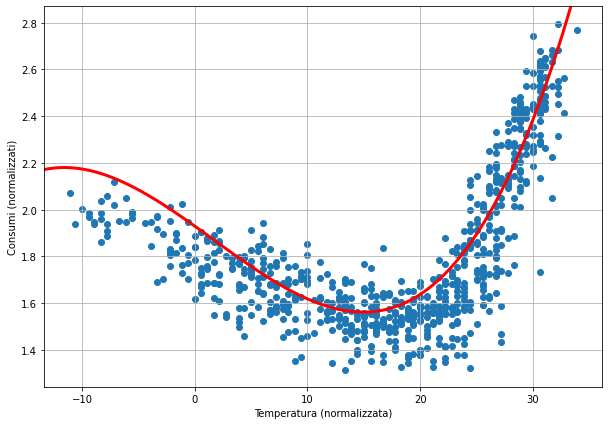

In [63]:
from sklearn.linear_model import LinearRegression
model = Pipeline([
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("regr", LinearRegression())
])
model.fit(power_X_train, power_y_train)
plot_model_on_data(power_X_val, power_y_val, model)
model.score(power_X_val, power_y_val)

- Vediamo ora per confronto cosa accade con un modello di regressione ad albero decisionale
- Tale tipo di modello è rappresentato da un oggetto `DecisionTreeRegressor`
- Gli iperparametri del modello consentono di regolare la complessità dell'albero risultante
- Ad esempio tramite il parametro `max_depth` possiamo controllare la profondità massima dell'albero
  - per ora la limitiamo a 2 per facilitare la lettura dell'albero stesso

In [64]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=2, random_state=42)

- Addestriamo il modello sulle variabili numeriche del dataset

In [65]:
model.fit(power_X_train, power_y_train)

DecisionTreeRegressor(max_depth=2, random_state=42)

- È stato così costruito un albero decisionale in base ai dati del training set
- L'albero può essere ispezionato per verificare quali variabili sono ritenute significative
- Per ottenere una rappresentazione testuale dell'albero, viene fornita la funzione `export_text`

In [66]:
from sklearn.tree import export_text
print(export_text(model))

|--- feature_0 <= 25.30
|   |--- feature_0 <= 4.15
|   |   |--- value: [1.98]
|   |--- feature_0 >  4.15
|   |   |--- value: [1.66]
|--- feature_0 >  25.30
|   |--- feature_0 <= 29.15
|   |   |--- value: [2.13]
|   |--- feature_0 >  29.15
|   |   |--- value: [2.48]



La rappresentazione mostra intuitivamente come il modello classifichi ciascun valore di temperatura (`feature_0`, l'unica presente)

- Se la temperatura è inferiore o uguale a 25,3 °C...
  - ...e inferiore o uguale a 4,15 °C, predici un consumo di 1,98 GW
  - ...e superiore a 4,15 °C, predici un consumo di 1,66 GW
- Se la temperatura è superiore a 25,3 °C...
  - ...e inferiore o uguale a 29,15 °C, predici un consumo di 2,13 GW
  - ...e superiore a 29,15 °C, predici un consumo di 2,48 GW

- In pratica sono stati delineati 4 intervalli di valori della temperatura e a ciascuno è stato assegnato un valore costante di consumi previsti
- Questo è evidente anche dal grafico del modello...

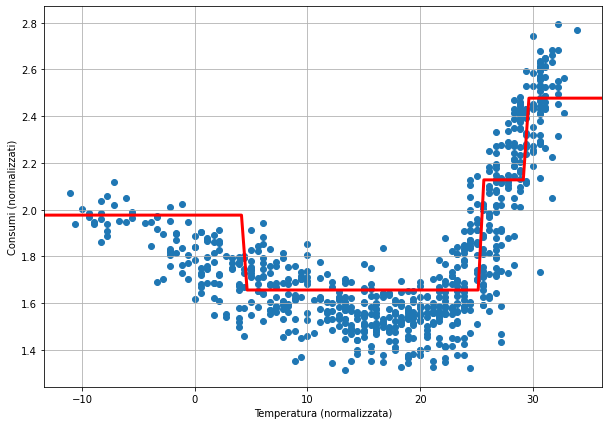

In [67]:
plot_model_on_data(power_X_val, power_y_val, model)

- Per visualizzare invece graficamente l'albero di un modello, viene fornita la funzione `plot_tree`

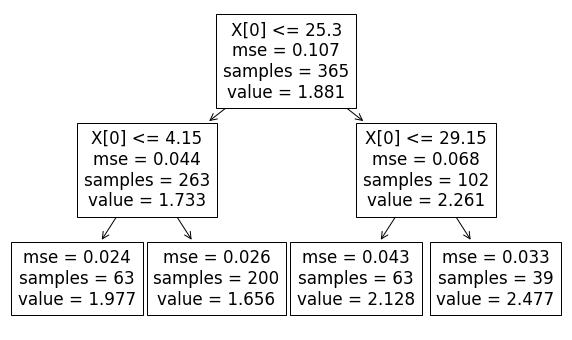

In [68]:
from sklearn.tree import plot_tree
plt.figure(figsize=(10, 6))
plot_tree(model);

- Ogni blocco rappresenta un nodo dell'albero
  - in cima alla figura viene mostrata la _radice_, il primo nodo valutato per classificare un'istanza
  - nella riga sotto si possono vedere i due nodi intermedi dell'albero
  - in fondo si possono vedere le quattro _foglie_, in cui viene deciso il valore predetto di y
- Il numero totale di foglie di un albero può essere ottenuto dal metodo `get_n_leaves`

In [69]:
model.get_n_leaves()

4

- Ad ogni nodo dell'albero sono mostrati in ordine
  - il criterio in base alla quale i dati sono suddivisi (assente nelle foglie)
    - se soddisfatta, viene seguito il ramo a sinistra del nodo
    - altrimenti, viene seguito il ramo a destra
  - l'errore quadratico, usato per definire la "qualità" della suddivisione
  - il numero totale di istanze del training set considerate (`samples`)
  - il valore medio della y per tali istanze, utilizzato come valore predetto nelle foglie (`value`)

- Per valutare l'accuratezza dell'albero decisionale in termini di coefficiente R² usiamo come al solito il metodo `score`
- Come si può dedurre anche dai grafici, questo albero poco profondo è meno accurato del modello polinomiale

In [70]:
model.score(power_X_val, power_y_val)

0.6756230654023873

- La situazione migliora aumentando la profondità massima dell'albero
- Ad es., passando da 2 a 3 il numero di foglie raddoppia e il modello è notevolmente più accurato

0.7233079538000284

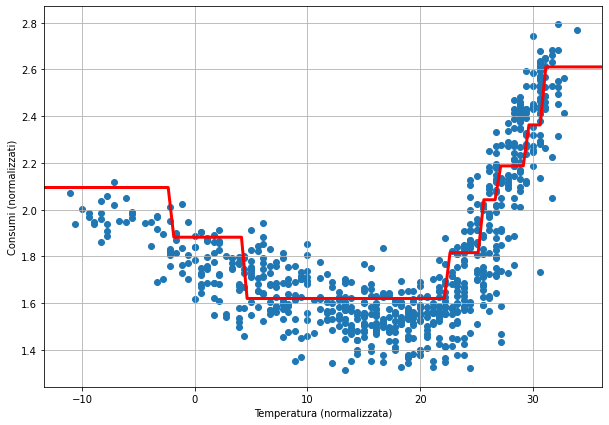

In [71]:
model = DecisionTreeRegressor(max_depth=3, random_state=42)
model.fit(power_X_train, power_y_train);
plot_model_on_data(power_X_val, power_y_val, model)
model.score(power_X_val, power_y_val)

- Torniamo ora sul problema di predizione delle vendite sui dati Rossman
- Addestriamo un albero con profondità massima 2

In [72]:
model = DecisionTreeRegressor(max_depth=2, random_state=42)
model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2, random_state=42)

- Usiamo la funzione `export_text` per visualizzare l'albero in forma testuale
  - specificare i nomi delle variabili come `feature_names` per usarle come etichette nell'albero

In [73]:
print(export_text(model, feature_names=X_names))

|--- Promo <= 0.10
|   |--- StoreType_2 <= 3.58
|   |   |--- value: [5855.05]
|   |--- StoreType_2 >  3.58
|   |   |--- value: [9540.35]
|--- Promo >  0.10
|   |--- Date_dayofweek <= -1.17
|   |   |--- value: [9761.90]
|   |--- Date_dayofweek >  -1.17
|   |   |--- value: [7817.48]



La rappresentazione mostra intuitivamente che:
- Per prima cosa si verifica se è in corso la promozione "primaria" (`Promo`)
  - se no, si verifica se il tipo di negozio (`StoreType`) è 2
    - se no, le vendite previste sono 5855,05 \$
    - se sì, le vendite previste sono 9540,35 \$
  - se sì, si verifica se è lunedì (la variabile `Date_dayofweek` standardizzata è inferiore a -1,17 solo se il suo valore originale è 0, corrispondente al lunedì)
    - se sì, le vendite previste sono 9761,90 \$
    - se no, le vendite previste sono 7817,48 \$

- Vediamo le stesse informazioni anche nella rappresentazione grafica (anche quì si può usare `feature_names`)

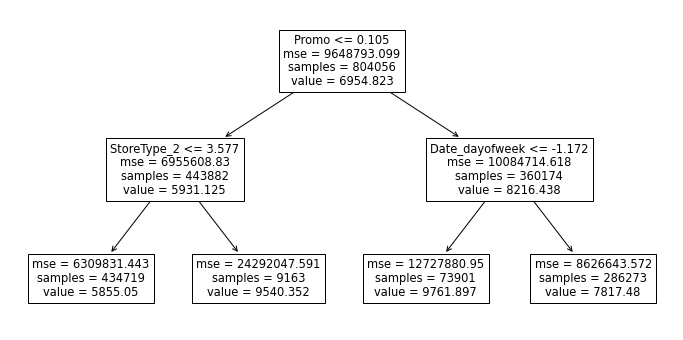

In [74]:
plt.figure(figsize=(12, 6))
plot_tree(model, feature_names=X_names);

- Con questo albero poco profondo, l'accuratezza della predizione è scarsa

In [75]:
model.score(X_train, y_train)

0.17818636020062428

In [76]:
model.score(X_val, y_val)

0.2179877444865257

- Proviamo ora ad addestrare un nuovo modello aumentando la profondità massima dell'albero da 2 a 5

In [77]:
model = DecisionTreeRegressor(max_depth=5, random_state=42)
model.fit(X_train, y_train);

- Stampando la rappresentazione testuale dell'albero, vediamo che è molto più complesso di quello sopra

In [78]:
print(export_text(model, feature_names=X_names))

|--- Promo <= 0.10
|   |--- StoreType_2 <= 3.58
|   |   |--- Assortment_1 <= -0.05
|   |   |   |--- CompetitionDistance <= -0.65
|   |   |   |   |--- Promo2SinceYear <= 1.00
|   |   |   |   |   |--- value: [8976.36]
|   |   |   |   |--- Promo2SinceYear >  1.00
|   |   |   |   |   |--- value: [6647.14]
|   |   |   |--- CompetitionDistance >  -0.65
|   |   |   |   |--- PromoOpen <= -1.00
|   |   |   |   |   |--- value: [5547.81]
|   |   |   |   |--- PromoOpen >  -1.00
|   |   |   |   |   |--- value: [6441.43]
|   |   |--- Assortment_1 >  -0.05
|   |   |   |--- Date_month <= 1.68
|   |   |   |   |--- Promo2SinceWeek <= -0.00
|   |   |   |   |   |--- value: [5636.34]
|   |   |   |   |--- Promo2SinceWeek >  -0.00
|   |   |   |   |   |--- value: [5083.80]
|   |   |   |--- Date_month >  1.68
|   |   |   |   |--- Date_dayofweek <= -1.17
|   |   |   |   |   |--- value: [8614.71]
|   |   |   |   |--- Date_dayofweek >  -1.17
|   |   |   |   |   |--- value: [6204.81]
|   |--- StoreType_2 >  3.58
|

- Il numero totale di foglie ora è:

In [79]:
model.get_n_leaves()

32

- Per rendere la stampa più compatta, possiamo indicare una `max_depth` in `export_text` per stampare i nodi solamente fino ad una profondità data
  - sono indicati i punti in cui la rappresentazione è stata tagliata, con la loro profondità

In [80]:
print(export_text(model, feature_names=X_names, max_depth=2))

|--- Promo <= 0.10
|   |--- StoreType_2 <= 3.58
|   |   |--- Assortment_1 <= -0.05
|   |   |   |--- truncated branch of depth 3
|   |   |--- Assortment_1 >  -0.05
|   |   |   |--- truncated branch of depth 3
|   |--- StoreType_2 >  3.58
|   |   |--- CompetitionOpenSinceYear <= 0.69
|   |   |   |--- truncated branch of depth 3
|   |   |--- CompetitionOpenSinceYear >  0.69
|   |   |   |--- truncated branch of depth 3
|--- Promo >  0.10
|   |--- Date_dayofweek <= -1.17
|   |   |--- Date_month <= 1.68
|   |   |   |--- truncated branch of depth 3
|   |   |--- Date_month >  1.68
|   |   |   |--- truncated branch of depth 3
|   |--- Date_dayofweek >  -1.17
|   |   |--- Date_month <= 1.68
|   |   |   |--- truncated branch of depth 3
|   |   |--- Date_month >  1.68
|   |   |   |--- truncated branch of depth 3



- Il parametro `max_depth` può essere utilizzato anche in `plot_tree`
  - si consiglia di utilizzarlo sempre, per evitare di generare figure "pesanti"
  - usare `fontsize` per regolare le dimensioni dei caratteri

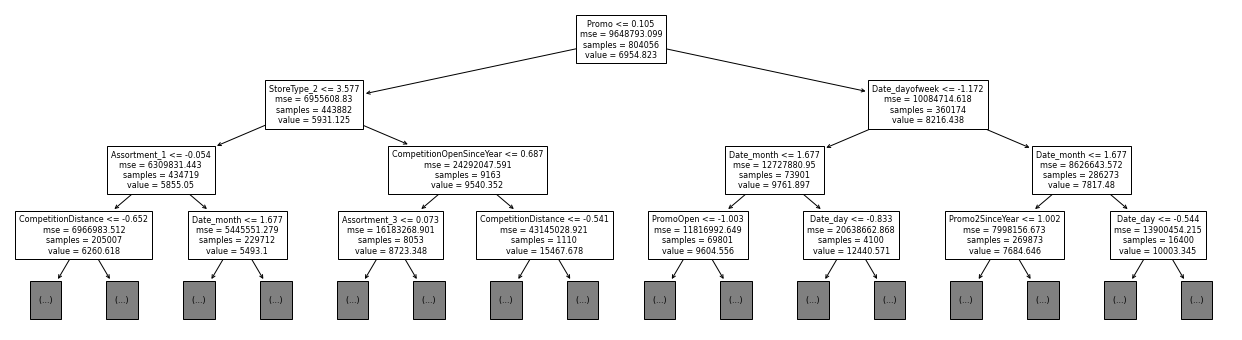

In [81]:
plt.figure(figsize=(22, 6))
plot_tree(model, feature_names=X_names, max_depth=3, fontsize=8);

- I riquadri grigi nella figura indicano le porzioni tagliate dell'albero
- Specificando `filled=True` in `plot_tree`, è possibile colorare i nodi in base alla "purezza", ovvero all'errore compiuto in essi
  - il colore è tanto più intenso quanto più è la purezza, ovvero quanto più la varianza della y è contenuta

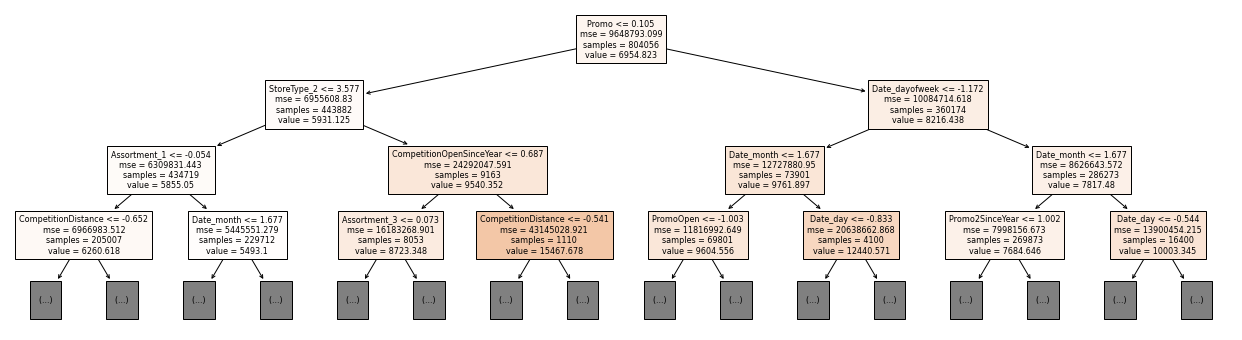

In [82]:
plt.figure(figsize=(22, 6))
plot_tree(model, feature_names=X_names, max_depth=3, filled=True, fontsize=8);

- L'accuratezza del modello è aumentata

In [83]:
model.score(X_train, y_train)

0.26636431825380036

In [84]:
model.score(X_val, y_val)

0.27675527247040177

- Oltre alla profondità massima, è possibile impostare altri criteri per limitare la complessità di un albero
- Ad esempio con `min_samples_split` viene impostato il numero minimo di casi di training (`samples`) contenuti in un nodo intermedio: nodi con un numero inferiore di casi non possono essere ulteriormente suddivisi
  - è possibile impostare sia un numero intero assoluto che una frazione rispetto ai casi di training
- Costruiamo ad esempio un albero decisionale impostando che i nodi devono contenere almeno 60.000 casi di training per essere suddivisi

In [85]:
model = DecisionTreeRegressor(min_samples_split=70000, random_state=42)
model.fit(X_train, y_train);

- Otteniamo un albero con un numero di foglie simile a quello con `max_depth=5`, ma più profondo

In [86]:
model.get_depth()

10

In [87]:
model.get_n_leaves()

30

- Questo perché col criterio `min_samples_split` otteniamo suddivisioni più profonde nei rami in cui ricadono molte istanze di training
- Questo si può osservare anche dalle rappresentazioni testuale e grafica dell'albero

In [88]:
print(export_text(model, feature_names=X_names, max_depth=2))

|--- Promo <= 0.10
|   |--- StoreType_2 <= 3.58
|   |   |--- Assortment_1 <= -0.05
|   |   |   |--- truncated branch of depth 8
|   |   |--- Assortment_1 >  -0.05
|   |   |   |--- truncated branch of depth 6
|   |--- StoreType_2 >  3.58
|   |   |--- value: [9540.35]
|--- Promo >  0.10
|   |--- Date_dayofweek <= -1.17
|   |   |--- Date_month <= 1.68
|   |   |   |--- value: [9604.56]
|   |   |--- Date_month >  1.68
|   |   |   |--- value: [12440.57]
|   |--- Date_dayofweek >  -1.17
|   |   |--- Date_month <= 1.68
|   |   |   |--- truncated branch of depth 6
|   |   |--- Date_month >  1.68
|   |   |   |--- value: [10003.35]



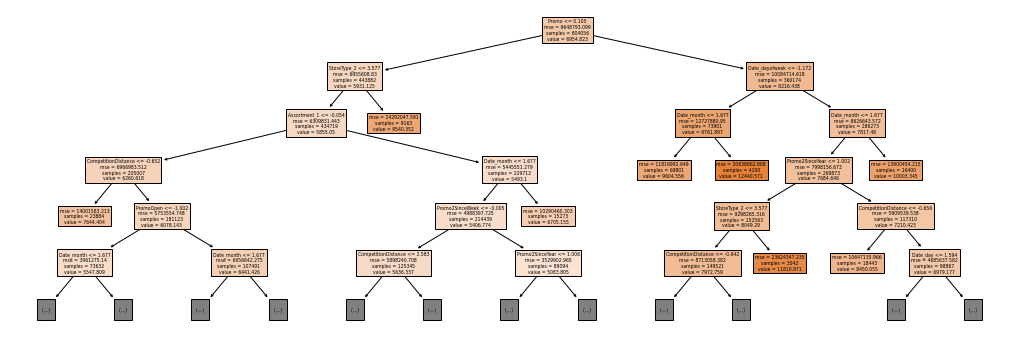

In [89]:
plt.figure(figsize=(18, 6))
plot_tree(model, feature_names=X_names, max_depth=5, filled=True);

- Si noti come la profondità massima dell'albero è 9, ma si trovano delle foglie già ai livelli superiori

In [90]:
model.score(X_train, y_train)

0.26050149948713064

In [91]:
model.score(X_val, y_val)

0.2774351131060361

- Come ulteriore misura di performance oltre a R² introduciamo il _Root Mean Squared Percentage Error_ (RMSPE), usato nella competizione Kaggle viene usata come misura di riferimento
$$ \textrm{RMSPE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{y_i - \hat{y}_i}{y_i}\right)^2} $$
- Definiamo una funzione `rmspe` per calcolare tale metrica dati i valori attesi e le predizioni

In [92]:
def rmspe(y_real, y_pred):
    #return np.sqrt((1/len(y_real))*np.sum(((y_real - y_pred) / y_real) ** 2))
    return np.sqrt(np.mean((y_pred /y_real - 1) ** 2))

- Creiamo una funzione `print_eval` per stampare MSE, R² e RMSPE di un modello

In [93]:
from sklearn.metrics import mean_squared_error, r2_score

def print_eval(X, y, model):
    y_pred = model.predict(X)
    print(f"      MSE: {mean_squared_error(y, y_pred):12.4f}")
    print(f"R-squared: {r2_score(y, y_pred):12.4f}")
    print(f"    RMSPE: {rmspe(y, y_pred):12.4f}")

In [94]:
print_eval(X_val, y_val, model)

      MSE: 6742281.3245
R-squared:       0.2774
    RMSPE:       0.4380


## Random Forest

- Random Forest è un algoritmo di tipo _bagging_: vengono creati numerosi alberi decisionali in parallelo, ognuno da un sottoinsieme del dataset di training in generale non disgiunto dagli altri
- Il bagging è uno tra i metodi di ensemble più efficaci perché ogni albero di regressione è generato da un subset leggermente diverso con prestazioni diverse
- A differenza dei modelli base di albero di regressione (e.g. CART), gli alberi di Random Forest non vengono potati, il che può renderli meno generali e più specifici per il relativo subset di dati di training
- Tuttavia, in questo caso, ciò è positivo perché rende ogni albero diverso con previsioni ed errori di previsione meno correlati
- Ogni previsione di Random Forest è data dalla media delle previsioni di tutti gli alberi decisionali e l'efficacia è migliore di qualsiasi singolo albero della propria foresta
- Random Forest è tra gli algoritmi più efficaci ed efficienti per dati tabulari

In [95]:
from sklearn.ensemble import RandomForestRegressor

- L'iperparametro `max_samples` è il numero (se intero) o la percentuale (se reale tra 0 e 1) di istanze del training set usate per addestrare ogni singolo albero
- Più la dimensione di `max_samples` è piccola, più gli alberi saranno diversi
  - il valore predefinito è 1 perciò occorre ridurlo
- Altri iperparametri importanti sono
  - il numero di feature casuali che deve avere ogni albero come sottoinsieme casuale di tutte le feature del training set `max_features`, usiamo "sqrt" per indicare la radice quadrata del numero totale di feature
  - la profondità massima di ogni albero `max_depth`
  - il numero di alberi `n_estimators`
- L'iperparametro `n_jobs=-1` (presente anche in altri algoritmi) indica di utilizzare tutte le CPU della macchina in parallelo

In [96]:
%%time
rfm = RandomForestRegressor(max_samples=0.2, max_features="sqrt", n_estimators=200, max_depth=None, n_jobs=-1)
rfm.fit(X_train, y_train)

Wall time: 25.3 s


RandomForestRegressor(max_features='sqrt', max_samples=0.2, n_estimators=200,
                      n_jobs=-1)

In [97]:
print_eval(X_val, y_val, rfm)

      MSE: 1833092.9444
R-squared:       0.8035
    RMSPE:       0.2299


- L'accuratezza è molto migliore rispetto all'albero singolo

### Selezione di feature con Random Forest

- Dai modelli ad albero è possibile ottenere l'importanza delle feature, calcolata in base a quante volte ciascuna feature è usata come discriminante
- I coefficienti di importanza sono ottenibili dall'attributo `feature_importances_`

In [98]:
rfm.feature_importances_

array([8.01819068e-02, 2.40468269e-01, 8.02315054e-02, 7.21772966e-02,
       3.45528643e-02, 2.57579543e-02, 5.79945365e-02, 1.26516349e-01,
       8.47589120e-03, 4.48967297e-03, 3.51629061e-03, 7.54152826e-04,
       4.57098271e-04, 2.05259833e-04, 4.20516228e-05, 1.53921544e-02,
       2.22599246e-02, 1.15355612e-02, 1.14690616e-02, 1.35936747e-02,
       2.75000374e-03, 1.32720969e-02, 6.14236285e-02, 4.59182148e-02,
       6.65645804e-02])

- Come per i coefficienti dei modelli di regressione lineare, possiamo usare una serie per associare i valori ai nomi e vedere quali sono le feature più importanti

In [99]:
pd.Series(rfm.feature_importances_, index=X_names).sort_values(ascending=False)

CompetitionDistance          0.240468
Promo                        0.126516
CompetitionOpenSinceMonth    0.080232
CompetitionOpen              0.080182
CompetitionOpenSinceYear     0.072177
Date_dayofweek               0.066565
Date_day                     0.061424
PromoOpen                    0.057995
Date_month                   0.045918
Promo2SinceWeek              0.034553
Promo2SinceYear              0.025758
StoreType_2                  0.022260
StoreType_1                  0.015392
Assortment_1                 0.013594
Assortment_3                 0.013272
StoreType_3                  0.011536
StoreType_4                  0.011469
SchoolHoliday                0.008476
Promo2                       0.004490
IsPromoMonth                 0.003516
Assortment_2                 0.002750
StateHoliday_0               0.000754
StateHoliday_1               0.000457
StateHoliday_2               0.000205
StateHoliday_3               0.000042
dtype: float64

## LightGBM: 
- LightGBM, abbreviazione di Light Gradient Boosted Machine, è una libreria sviluppata da Microsoft che fornisce un'implementazione efficiente dell'algoritmo di gradient boosting spiegato [a lezione](https://www.dropbox.com/s/4o8dg87274x0yae/08_bis_Aula_Introduzione_regression_decision_tree_e_xgboost.pdf?dl=0)
- Il vantaggio principale di LightGBM sono alcune variazioni all'algoritmo di addestramento che rendono il processo molto più veloce e spesso ottenendo modelloi più efficaci
- Per ulteriori dettagli tecnici sull'algoritmo LightGBM è disponibile il sito https://github.com/microsoft/LightGBM ed il paper https://arxiv.org/abs/1810.11363

In [100]:
#%conda install lightgbm

In [101]:
from lightgbm import LGBMRegressor

In [102]:
%%time
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)

Wall time: 4.1 s


LGBMRegressor()

- L'addestramento è relativamente rapido ma il modello è meno efficace di Random Forest

In [103]:
print_eval(X_val, y_val, lgbm)

      MSE: 3559708.4347
R-squared:       0.6185
    RMSPE:       0.3503


## XGBoost

- La libreria `xgboost` fornisce un'implementazione dell'omonimo algoritmo (_eXtreme Gradient Boosting_)

In [104]:
#%conda install xgboost

In [105]:
import xgboost
print(xgboost.__version__)

1.5.0


In [106]:
from xgboost import XGBRegressor

In [107]:
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(data_train["Sales"].values[:, None]).ravel()
y_val = scaler_y.transform(data_val["Sales"].values[:, None]).ravel()

In [108]:
%%time
xgbm = XGBRegressor(objective='reg:squarederror', reg_alpha=0.0, reg_lambda=1.0, n_estimators=200)
xgbm.fit(X_train, y_train)

Wall time: 45.9 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.0, reg_lambda=1.0, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [109]:
print_eval(X_val, y_val, xgbm)

      MSE:       0.1273
R-squared:       0.8684
    RMSPE:      61.7137


- Il modello di regressione lineare ottiene un RMSPE pari a 0.4672, mentre xgboost senza tuning degli iperparametri 0.2235. Il miglior risultato nella competion kaggle è 0.13. XGBoost con 200 alberi ottiene 0.18 e con 400 alberi 0.1671.

In [110]:
pd.Series(xgbm.feature_importances_, index=X_names).sort_values(ascending=False)

StoreType_2                  0.177456
Promo                        0.103103
Promo2SinceYear              0.082462
CompetitionOpenSinceYear     0.077235
Assortment_3                 0.063858
CompetitionOpenSinceMonth    0.062137
Assortment_1                 0.058634
CompetitionDistance          0.053881
Promo2SinceWeek              0.051699
StoreType_4                  0.043286
StoreType_1                  0.041262
StoreType_3                  0.039349
Date_month                   0.025888
Date_dayofweek               0.023566
Date_day                     0.021533
CompetitionOpen              0.017456
PromoOpen                    0.014422
SchoolHoliday                0.014399
StateHoliday_0               0.009955
IsPromoMonth                 0.006929
Assortment_2                 0.005116
StateHoliday_2               0.003625
StateHoliday_1               0.001623
StateHoliday_3               0.001125
Promo2                       0.000000
dtype: float32

## CatBoost: Category Gradient Boosting

- Supporta nativamente variabili categoriche ossia nominal.
- https://catboost.ai/

In [111]:
#%conda install catboost

In [112]:
import catboost
print(catboost.__version__)
from catboost import CatBoostRegressor

0.26.1


In [113]:
# istanziazione e addestramento: con 1000 estimatori richiede due minuti
import datetime
start = datetime.datetime.now()
catbm = CatBoostRegressor(n_estimators=1000);
catbm.fit(X_train, y_train);
end = datetime.datetime.now()
print(f"{int((end - start).total_seconds())}s")

Learning rate set to 0.128393
0:	learn: 0.9690351	total: 234ms	remaining: 3m 53s
1:	learn: 0.9444538	total: 300ms	remaining: 2m 29s
2:	learn: 0.9250592	total: 364ms	remaining: 2m 1s
3:	learn: 0.9090002	total: 434ms	remaining: 1m 48s
4:	learn: 0.8953388	total: 507ms	remaining: 1m 40s
5:	learn: 0.8844197	total: 575ms	remaining: 1m 35s
6:	learn: 0.8758340	total: 640ms	remaining: 1m 30s
7:	learn: 0.8660897	total: 728ms	remaining: 1m 30s
8:	learn: 0.8600040	total: 797ms	remaining: 1m 27s
9:	learn: 0.8517346	total: 870ms	remaining: 1m 26s
10:	learn: 0.8467222	total: 937ms	remaining: 1m 24s
11:	learn: 0.8406667	total: 1.01s	remaining: 1m 23s
12:	learn: 0.8358039	total: 1.08s	remaining: 1m 21s
13:	learn: 0.8314287	total: 1.15s	remaining: 1m 20s
14:	learn: 0.8282308	total: 1.21s	remaining: 1m 19s
15:	learn: 0.8253200	total: 1.27s	remaining: 1m 17s
16:	learn: 0.8217496	total: 1.33s	remaining: 1m 17s
17:	learn: 0.8186483	total: 1.41s	remaining: 1m 16s
18:	learn: 0.8149678	total: 1.48s	remaining: 

159:	learn: 0.6109097	total: 11.7s	remaining: 1m 1s
160:	learn: 0.6097763	total: 11.8s	remaining: 1m 1s
161:	learn: 0.6080247	total: 11.8s	remaining: 1m 1s
162:	learn: 0.6074782	total: 11.9s	remaining: 1m 1s
163:	learn: 0.6066991	total: 12s	remaining: 1m 1s
164:	learn: 0.6047115	total: 12.1s	remaining: 1m
165:	learn: 0.6034599	total: 12.1s	remaining: 1m
166:	learn: 0.6032304	total: 12.2s	remaining: 1m
167:	learn: 0.6019031	total: 12.3s	remaining: 1m
168:	learn: 0.6011976	total: 12.3s	remaining: 1m
169:	learn: 0.6008792	total: 12.4s	remaining: 1m
170:	learn: 0.5988262	total: 12.5s	remaining: 1m
171:	learn: 0.5973139	total: 12.5s	remaining: 1m
172:	learn: 0.5956006	total: 12.6s	remaining: 1m
173:	learn: 0.5949824	total: 12.7s	remaining: 1m
174:	learn: 0.5942026	total: 12.8s	remaining: 1m
175:	learn: 0.5934297	total: 12.8s	remaining: 1m
176:	learn: 0.5921538	total: 12.9s	remaining: 1m
177:	learn: 0.5918313	total: 13s	remaining: 1m
178:	learn: 0.5914793	total: 13.1s	remaining: 60s
179:	lea

319:	learn: 0.5041508	total: 23.5s	remaining: 50s
320:	learn: 0.5036790	total: 23.6s	remaining: 50s
321:	learn: 0.5033884	total: 23.7s	remaining: 49.9s
322:	learn: 0.5030168	total: 23.8s	remaining: 49.9s
323:	learn: 0.5025796	total: 23.9s	remaining: 49.8s
324:	learn: 0.5022926	total: 23.9s	remaining: 49.7s
325:	learn: 0.5018650	total: 24s	remaining: 49.7s
326:	learn: 0.5016291	total: 24.1s	remaining: 49.6s
327:	learn: 0.5010620	total: 24.2s	remaining: 49.5s
328:	learn: 0.5008851	total: 24.2s	remaining: 49.4s
329:	learn: 0.5007210	total: 24.3s	remaining: 49.4s
330:	learn: 0.5005709	total: 24.4s	remaining: 49.3s
331:	learn: 0.4997995	total: 24.5s	remaining: 49.2s
332:	learn: 0.4994123	total: 24.5s	remaining: 49.1s
333:	learn: 0.4989215	total: 24.6s	remaining: 49.1s
334:	learn: 0.4981007	total: 24.7s	remaining: 49s
335:	learn: 0.4973689	total: 24.8s	remaining: 48.9s
336:	learn: 0.4963339	total: 24.8s	remaining: 48.8s
337:	learn: 0.4960093	total: 24.9s	remaining: 48.7s
338:	learn: 0.495669

479:	learn: 0.4447690	total: 35.3s	remaining: 38.2s
480:	learn: 0.4445131	total: 35.4s	remaining: 38.2s
481:	learn: 0.4442375	total: 35.4s	remaining: 38.1s
482:	learn: 0.4439126	total: 35.5s	remaining: 38s
483:	learn: 0.4435356	total: 35.6s	remaining: 38s
484:	learn: 0.4433937	total: 35.7s	remaining: 37.9s
485:	learn: 0.4429662	total: 35.7s	remaining: 37.8s
486:	learn: 0.4426346	total: 35.8s	remaining: 37.7s
487:	learn: 0.4423356	total: 35.9s	remaining: 37.6s
488:	learn: 0.4420582	total: 36s	remaining: 37.6s
489:	learn: 0.4419822	total: 36s	remaining: 37.5s
490:	learn: 0.4417500	total: 36.1s	remaining: 37.4s
491:	learn: 0.4415480	total: 36.2s	remaining: 37.3s
492:	learn: 0.4412643	total: 36.2s	remaining: 37.3s
493:	learn: 0.4409179	total: 36.3s	remaining: 37.2s
494:	learn: 0.4407460	total: 36.4s	remaining: 37.1s
495:	learn: 0.4400046	total: 36.5s	remaining: 37s
496:	learn: 0.4398331	total: 36.5s	remaining: 37s
497:	learn: 0.4396757	total: 36.6s	remaining: 36.9s
498:	learn: 0.4395053	to

641:	learn: 0.4073462	total: 46.9s	remaining: 26.2s
642:	learn: 0.4072365	total: 47s	remaining: 26.1s
643:	learn: 0.4069126	total: 47s	remaining: 26s
644:	learn: 0.4066397	total: 47.1s	remaining: 25.9s
645:	learn: 0.4064220	total: 47.2s	remaining: 25.9s
646:	learn: 0.4061351	total: 47.3s	remaining: 25.8s
647:	learn: 0.4059195	total: 47.3s	remaining: 25.7s
648:	learn: 0.4057968	total: 47.4s	remaining: 25.6s
649:	learn: 0.4056658	total: 47.5s	remaining: 25.6s
650:	learn: 0.4053479	total: 47.5s	remaining: 25.5s
651:	learn: 0.4050856	total: 47.6s	remaining: 25.4s
652:	learn: 0.4049756	total: 47.7s	remaining: 25.3s
653:	learn: 0.4048604	total: 47.7s	remaining: 25.3s
654:	learn: 0.4047457	total: 47.8s	remaining: 25.2s
655:	learn: 0.4045554	total: 47.9s	remaining: 25.1s
656:	learn: 0.4044863	total: 47.9s	remaining: 25s
657:	learn: 0.4042606	total: 48s	remaining: 25s
658:	learn: 0.4040571	total: 48.1s	remaining: 24.9s
659:	learn: 0.4038862	total: 48.2s	remaining: 24.8s
660:	learn: 0.4037770	to

802:	learn: 0.3823069	total: 58.6s	remaining: 14.4s
803:	learn: 0.3822403	total: 58.6s	remaining: 14.3s
804:	learn: 0.3820750	total: 58.7s	remaining: 14.2s
805:	learn: 0.3819633	total: 58.8s	remaining: 14.1s
806:	learn: 0.3818519	total: 58.8s	remaining: 14.1s
807:	learn: 0.3816712	total: 58.9s	remaining: 14s
808:	learn: 0.3815930	total: 59s	remaining: 13.9s
809:	learn: 0.3813019	total: 59.1s	remaining: 13.9s
810:	learn: 0.3810826	total: 59.1s	remaining: 13.8s
811:	learn: 0.3810260	total: 59.2s	remaining: 13.7s
812:	learn: 0.3808833	total: 59.3s	remaining: 13.6s
813:	learn: 0.3807034	total: 59.4s	remaining: 13.6s
814:	learn: 0.3806207	total: 59.5s	remaining: 13.5s
815:	learn: 0.3804408	total: 59.5s	remaining: 13.4s
816:	learn: 0.3803863	total: 59.6s	remaining: 13.3s
817:	learn: 0.3802004	total: 59.7s	remaining: 13.3s
818:	learn: 0.3801181	total: 59.7s	remaining: 13.2s
819:	learn: 0.3800628	total: 59.8s	remaining: 13.1s
820:	learn: 0.3799831	total: 59.9s	remaining: 13.1s
821:	learn: 0.37

962:	learn: 0.3625472	total: 1m 10s	remaining: 2.7s
963:	learn: 0.3624756	total: 1m 10s	remaining: 2.63s
964:	learn: 0.3623651	total: 1m 10s	remaining: 2.56s
965:	learn: 0.3622397	total: 1m 10s	remaining: 2.48s
966:	learn: 0.3621906	total: 1m 10s	remaining: 2.41s
967:	learn: 0.3621480	total: 1m 10s	remaining: 2.34s
968:	learn: 0.3620902	total: 1m 10s	remaining: 2.26s
969:	learn: 0.3619560	total: 1m 10s	remaining: 2.19s
970:	learn: 0.3617515	total: 1m 10s	remaining: 2.12s
971:	learn: 0.3615709	total: 1m 11s	remaining: 2.04s
972:	learn: 0.3614088	total: 1m 11s	remaining: 1.97s
973:	learn: 0.3612890	total: 1m 11s	remaining: 1.9s
974:	learn: 0.3612207	total: 1m 11s	remaining: 1.83s
975:	learn: 0.3611463	total: 1m 11s	remaining: 1.75s
976:	learn: 0.3610543	total: 1m 11s	remaining: 1.68s
977:	learn: 0.3610000	total: 1m 11s	remaining: 1.61s
978:	learn: 0.3608669	total: 1m 11s	remaining: 1.53s
979:	learn: 0.3607336	total: 1m 11s	remaining: 1.46s
980:	learn: 0.3605898	total: 1m 11s	remaining: 1

In [114]:
# valutazione di CatBoost: su questo caso di studio e senza tuning degli iperparametri è competitivo con XGBoost anche se quest'ultimo risulta comunque il migliore  
print_eval(X_val, y_val, catbm)

      MSE:       0.1471
R-squared:       0.8479
    RMSPE:      66.9580
